In [1]:
import math
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy.stats import bootstrap
from scipy import stats
import os
pd.options.mode.chained_assignment = None 

Functions

In [2]:
def plot_lowess(x, y, **kwargs):
    '''Plots lowess line depending on fraction'''
    
    z = lowess(np.array(y),np.array(x),frac=0.3)
    y2 = z[:,1]
    plt.plot(x,y2, **kwargs)

def plot_ci(x, y1, y2, **kwargs):
    plt.fill_between(x, y1, y2, **kwargs)
    
def plot_bar_ci(xs, y1s, y2s, **kwargs):
    for x,y1,y2 in zip(xs,y1s,y2s):
        plt.plot([x, x], [y1, y2], **kwargs)
        
def classify(n, bins):
    rbins = bins #[0] + bins + [1]
    for i,b in enumerate(rbins):
        if i==0:
            if n<=b:
                return np.round(b, decimals=2)
        else:
            if n>rbins[i-1] and n<=b:
                return np.round(b, decimals=2)

Read data

In [3]:
species = ["rattle","corn","garter"]

n_chunks = 200
form_chunks = [str(x+1).zfill(3) for x in range(n_chunks)]

sbam_l = []

for sp in species:
    print(sp)
    for chunk in form_chunks:
        if chunk=="192":
            continue
        df = pd.read_csv("../stats_bam/{}.{}.stab.tab.gz".format(sp, chunk), 
                         sep="\t", 
                         header=None)
        df.columns = ["n_reads", "bp_covered", "frac_covered", 
                      "dp", "baseQ","MQ","scaf", 
                      "start", "end", "start_rel_pos"]
        df["species"] = sp
        sbam_l.append(df)

sbam = pd.concat(sbam_l)

rattle
corn
garter


Apply some filters

In [4]:
#sbam["rel_pos"] = [np.round(r, decimals=1) for r in sbam.start_rel_pos]
bins = np.linspace(0,1,26)
sbam["rel_pos"] = [n/10e3 for n in sbam.start_rel_pos]
sbam["width"] = sbam.end-sbam.start
sbam = sbam[~(sbam.scaf.str.contains("-un")) | 
            ~(sbam.scaf.str.contains("NW"))].reset_index(drop=True)
sbam = sbam[sbam.dp<2e3]
#sbam = sbam[sbam.width.between(0,800)]
#sel_chroms = ["NC_045545.1","scaffold-ma1","Super_scaffold_349"]
#sbam = sbam[sbam.scaf.isin(sel_chroms)]

Sumarize statistics by relative position to island center

In [5]:
#sbam.groupby(["species","rel_pos"])[svars].mean()

results_l = []
group_vars = ["species", "rel_pos"]
svars = ["frac_covered", "dp", "baseQ", "MQ"]
func = np.mean

norm = True
normv = sbam[~sbam.rel_pos.between(0.4,0.6)].groupby("species")[svars].mean().to_dict()

for comb, df in sbam.groupby(group_vars):
    for v in svars:
        if len(df[v])>=10:
            boot = bootstrap(data=(df[v].values,), 
                             statistic=func,
                             n_resamples=50, 
                             method="percentile")
            ci = list(boot.confidence_interval)
            mean = func(df[v])
            if norm:
                vnorm = normv[v][comb[0]]
                ci = [cv/vnorm for cv in ci]
                mean = mean/vnorm
            counts = len(df)
            results_l.append(list(comb) + [mean, counts] + ci + [v])

mbci = pd.DataFrame(results_l)
mbci.columns = group_vars + ["mean", "n", "low", "high", "variable"]

Plotting

In [9]:
mbci["rel_pos2"] = mbci.rel_pos - 0.5

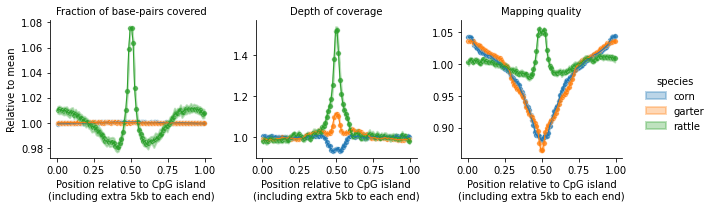

In [10]:
g = sns.FacetGrid(data=mbci[(mbci.rel_pos.between(0,1)) & (mbci.variable!="baseQ")], sharey=False,
                  col="variable", hue="species")

g.map(sns.scatterplot, "rel_pos", "mean", s=30, alpha=0.8)
g.map(sns.lineplot, "rel_pos", "mean", linewidth=1)
g.map(plot_ci, "rel_pos", "low", "high", linewidth=2, alpha=0.3)
#g.map(plot_lowess, "rel_pos", "low")

g.add_legend()
g.set_titles(row_template = '{row_name}', 
             col_template = '{col_name}')
g.set_axis_labels("Position relative to CpG island\n(including extra 5kb to each end)", 
                  "Relative to mean")

labels = ["Fraction of base-pairs covered", "Depth of coverage", "Mapping quality"]
for i,(var,ax) in enumerate(g.axes_dict.items()):
    ax.set_title(labels[i], fontsize=10)
    
g.tight_layout()

g.savefig("pdfs/bamstats_refindv_islands.jpg", dpi=400)
g.savefig("pdfs/bamstats_refindv_islands.pdf")

Complete stats

In [34]:
species = ["rattle","corn"]

n_chunks = 200
form_chunks = [str(x+1).zfill(3) for x in range(n_chunks)]

sfast_l = []

for sp in species:
    for chunk in form_chunks:
        file = "../stats_complete/{}.{}.tab.gz".format(sp, chunk)
        if os.path.isfile(file):
            if os.stat(file).st_size>0:
                df = pd.read_csv(file, 
                                 sep="\t", 
                                 header=None)
                df.columns = ["scaf","start", "end",
                              "n_reads", "bp_covered", "frac_covered", 
                              "dp", "baseQ","MQ", 
                              "gc", "width", "rmsk", 
                              "gap", "cpg","exp_cpg",
                              "id", "rrate", "prdm9_hits", 
                              "n_poly", "avg_r2"]

                df["species"] = sp
                sfast_l.append(df)

sfast = pd.concat(sfast_l)
sfast["log_rrate"] = np.log10(sfast.rrate)

In [35]:
#subd = sfast[(~sfast.id.str.contains("-un")) &
#             (~sfast.id.str.contains("NW"))] 
subd = sfast
svars = ["gc", "width", "cpg","dp", "baseQ","MQ"]#"log_rrate","prdm9_hits"
#subd["dp"] = [depth if depth<200 else 200 for depth in subd.dp]
subd["width"] = [width if width<1e3 else 1e3 for width in subd["width"]]
sqfast = subd.melt(id_vars=["species","id"], value_vars=svars)

In [36]:
sfast.groupby("species")["scaf"].count()

species
corn      60203
rattle    22585
Name: scaf, dtype: int64

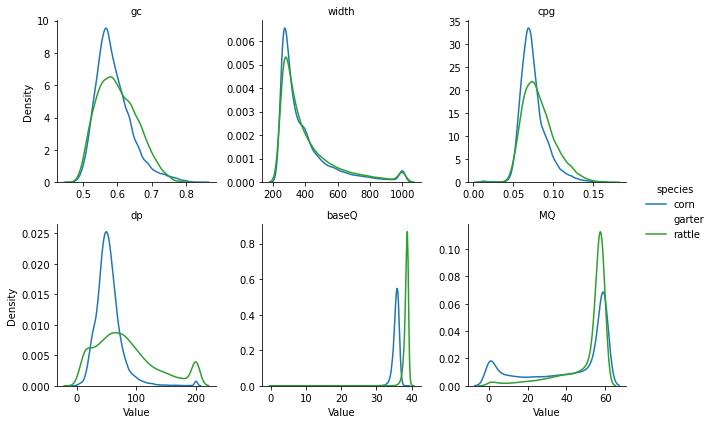

In [6]:
g = sns.FacetGrid(data=sqfast, col="variable", 
                  hue = "species", hue_order=["corn","garter","rattle"],
                  col_wrap=3,
                  sharex=False, sharey=False)
g.map(sns.kdeplot, "value")
#g.map(sns.boxplot, "species", "value")
g.add_legend()
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Value", "Density")
g.tight_layout()
#g.savefig("pdfs/vars_distribs.pdf")

corn 972
corn SpearmanrResult(correlation=0.00792495767699279, pvalue=0.8050926734840584)
corn PearsonRResult(statistic=0.05065899436867923, pvalue=0.11448009836669078)
rattle 9804
rattle SpearmanrResult(correlation=-0.03266370467142052, pvalue=0.0012179094629659946)
rattle PearsonRResult(statistic=-0.017948789267527514, pvalue=0.07554872740642156)


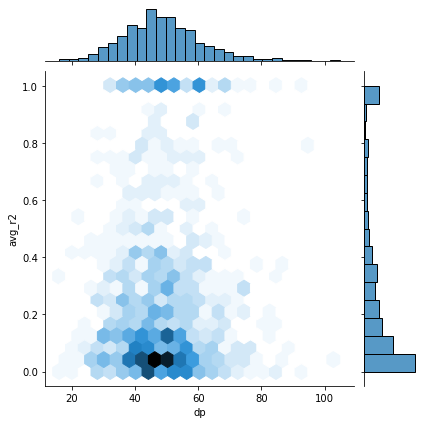

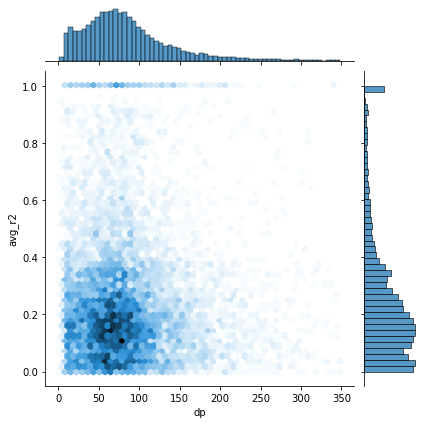

In [49]:
x = "dp"
y = "avg_r2"

for sp,df in sfast.groupby("species"):
#    if sp=="corn":
#        continue
    sdf = df[df.n_poly>0]
    sdf = sdf[sdf.dp<350]
    sdf = sdf[[x,y]].dropna()
    print(sp, len(sdf))
    #sdf[x] = np.log10(sdf[x])
    #sdf[y] = np.log10(sdf[y])
    print(sp, stats.spearmanr(sdf[x], sdf[y]))
    print(sp, stats.pearsonr(sdf[x], sdf[y]))
    g = sns.jointplot(data=sdf, x=x, y=y, kind="hex")